In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(".")
import HOD
import HOD_lowz

from scipy import integrate
from scipy import special

import mpmath
from hmf import MassFunction
from halomod.bias import Tinker10
from astropy.cosmology import FlatLambdaCDM
cosmo  = FlatLambdaCDM(H0=67.74, Om0=0.3089, Tcmb0=2.725)
OmegaM = cosmo.Om(0)
OmegaL = cosmo.Ode(0)
OmegaK = cosmo.Ok(0)
OmegaB = 0.049
OmegaC = OmegaM-OmegaB
H0 = cosmo.H(0).value
h  = H0/100
c_light  = 299792.458

/Users/giofer/anaconda3/envs/HOD/lib/python3.11/site-packages/halomod/halo_exclusion.py:18: UserWarning: Warning: Some Halo-Exclusion models have significant speedup when using Numba
  warnings.warn(


In [203]:
############ Test integration ############
_theta_ = 1

z = 1.7
M_sat, M_min, sigma_logM, alpha = 10**14.18, 10**12.46, 0.2, 1.0
z_array = np.array([1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2])
N_z_nrm = np.array([0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0])

_PS_NORM_ = HOD.norm_power_spectrum()
M_h_array, HMF_array, nu_array, hmf_k, hmf_PS = HOD.init_lookup_table(z, REWRITE_TBLS=False)
NCEN = HOD.N_cen(M_h_array, M_min, sigma_logM)
NSAT = HOD.N_sat(M_h_array, M_sat, alpha, M_min, sigma_logM)
D_ratio   = (HOD.D_growth_factor(z)/HOD.D_growth_factor(0))**2 if z != 0 else 1
bias = Tinker10(nu=nu_array).bias() if 1 else HOD.halo_bias_TINKER(nu_array)
N_G  = HOD.n_g(M_min, sigma_logM, M_sat, alpha, z, M_h_array, HMF_array)
comoving_distance_z = cosmo.comoving_distance(z).value
crit_dens_rescaled = (4/3*np.pi*cosmo.critical_density(z).value*200*2e40)

def F_k_hmf_func(k, M_min, sigma_logM, M_sat, alpha, z, crit_dens_rescaled, M_h_array,
                 HMF_array, N_G, NCEN, NSAT, bias, hmf_k, hmf_PS, D_ratio, _PS_NORM_, USE_MY_PS = 1):
    PS_1 = HOD.PS_1h(k, M_min, sigma_logM, M_sat, alpha, z, crit_dens_rescaled, M_h_array,
                     HMF_array, N_G, NCEN, NSAT)
    PS_2 = HOD.PS_2h(k, M_min, sigma_logM, M_sat, alpha, z, crit_dens_rescaled, M_h_array,
                     HMF_array, N_G, NCEN, NSAT, bias, hmf_k, hmf_PS, D_ratio, _PS_NORM_, USE_MY_PS)
    PS_2_corr =  PS_2 if USE_MY_PS else hmf_PS * PS_2
    factor = HOD.factor_k(k, _theta_/206265, comoving_distance_z)
    return np.array((PS_1 + PS_2_corr) * factor) if USE_MY_PS else np.array((PS_1 + PS_2_corr) * factor)[0] #INDEX ZERO IS WRONG!!!

def func(x, M_min, sigma_logM, M_sat, alpha, z, crit_dens_rescaled, M_h_array,
         HMF_array, N_G, NCEN, NSAT, bias, hmf_k, hmf_PS, D_ratio, _PS_NORM_, USE_MY_PS = 1):
    k = x / (_theta_ / 206265 * comoving_distance_z)
    return F_k_hmf_func(k, M_min, sigma_logM, M_sat, alpha, z, crit_dens_rescaled, M_h_array,
                        HMF_array, N_G, NCEN, NSAT, bias, hmf_k, hmf_PS, D_ratio, _PS_NORM_, USE_MY_PS)

j_0_zeros = np.append(1e-4, special.jn_zeros(0,1_000))
_prec = 1e-2
_args_ = M_min, sigma_logM, M_sat, alpha, z, crit_dens_rescaled, M_h_array, HMF_array, N_G, NCEN, NSAT, bias, hmf_k, hmf_PS, D_ratio, _PS_NORM_
INT_hmf = [integrate.quad(func, j_0_zero, j_0_zeros[ij+1], epsabs=_prec, epsrel=_prec, args = (_args_)) for ij, j_0_zero in enumerate(j_0_zeros[:-1])]
INT_hmf = np.reshape(INT_hmf, (len(j_0_zeros)-1, 2))
k_min = np.around(np.log10(np.min(j_0_zeros / (_theta_ / 206265 * comoving_distance_z))),2)
k_max = np.around(np.log10(np.max(j_0_zeros / (_theta_ / 206265 * comoving_distance_z))),2)
print(f'k_min: {k_min}, k_max: {k_max}')
print(j_0_zeros[:3], '...', j_0_zeros[-3:])
print(INT_hmf[:3,0], '...', INT_hmf[-3:,0])
np.sum(INT_hmf[:,0]), np.abs((np.sum(INT_hmf[:,0])-np.sum(INT_hmf[:-1,0]))/np.sum(INT_hmf[:,0]))

k_min: -2.37, k_max: 5.13
[1.00000000e-04 2.40482556e+00 5.52007811e+00] ... [3134.52411    3137.66570261 3140.80729523]
[252.12328681 -57.42043309  24.80853455] ... [-0.00272015  0.00271654 -0.00271248]


(210.7307282303074, 1.287177721563125e-05)

In [172]:
import multiprocessing
from multiprocessing.shared_memory import SharedMemory
import uuid
import sys

NZEROS = 10_000
mem_id = None
_prec = 1e-1
_args_ = M_min, sigma_logM, M_sat, alpha, z, crit_dens_rescaled,\
         M_h_array, HMF_array, N_G, NCEN, NSAT, bias, hmf_k, hmf_PS,\
         D_ratio, _PS_NORM_, USE_MY_PS

def init(mem):
    global mem_id
    mem_id = mem
    return

def make_integral_array(args):
    _args_, shape, nsrc, job_id = args
    shmem = SharedMemory(name=f'integr_{mem_id}', create=False)
    intgr = np.ndarray(shape, buffer=shmem.buf, dtype=np.float64)
    start = job_id * nsrc
    end = start + nsrc
    j0zs = np.append(1e-3, special.jn_zeros(0,10000))[start:end]
    INT_hmf = [integrate.quad(func, j0z, j0zs[ij+1], epsabs=_prec, epsrel=_prec, args = (_args_))[0] for ij, j0z in enumerate(j0zs[:-1])]
    intgr[start:end] = INT_hmf
    return

def make_integral_array_sharemem(_args = _args_, nzeros=NZEROS, cores=None):
    if cores is None:
        cores = multiprocessing.cpu_count()
        print(f'# Cores: {cores}')

    args =  [(_args, nzeros, nzeros//int(cores), i) for i in range(int(cores))]
    exit = False
    try:
        global mem_id
        mem_id = str(uuid.uuid4())
        nbytes = nzeros * np.float64(1).nbytes
        shd_mem = SharedMemory(name=f'integr_{mem_id}', create=True, size=nbytes)
        method = 'spawn'
        if sys.platform.startswith('linux'):
            method = 'fork'
        ctx = multiprocessing.get_context(method)
        pool = ctx.Pool(processes=cores, maxtasksperchild=1,
                        initializer=init, initargs=(mem_id,)
                        )
        try:
            pool.map_async(make_integral_array, args, chunksize=1).get(timeout=10_000)
        except KeyboardInterrupt:
            print("Caught kbd interrupt")
            pool.close()
            exit = True
        else:
            pool.close()
            pool.join()
            local_itgrd = np.ndarray(nzeros, buffer=shd_mem.buf, dtype=np.float64).copy()
    finally:
        shd_mem.close()
        shd_mem.unlink()
        if exit:
            sys.exit(1)
    return local_itgrd

make_integral_array_sharemem()


# Cores: 10


UnboundLocalError: cannot access local variable 'shd_mem' where it is not associated with a value

In [122]:
def F_k_hmf_func(k, M_min, sigma_logM, M_sat, alpha, z, crit_dens_rescaled, M_h_array,
                 HMF_array, N_G, NCEN, NSAT, bias, hmf_k, hmf_PS, D_ratio, _PS_NORM_, USE_MY_PS):
    PS_1 = HOD.PS_1h(k, M_min, sigma_logM, M_sat, alpha, z, crit_dens_rescaled, M_h_array,
                     HMF_array, N_G, NCEN, NSAT)
    PS_2 = HOD.PS_2h(k, M_min, sigma_logM, M_sat, alpha, z, crit_dens_rescaled, M_h_array,
                     HMF_array, N_G, NCEN, NSAT, bias, hmf_k, hmf_PS, D_ratio, _PS_NORM_, USE_MY_PS)
    PS_2_corr =  PS_2 if USE_MY_PS else hmf_PS * PS_2
    factor = HOD.factor_k(k, _theta_/206265, comoving_distance_z)
    return np.array((PS_1 + PS_2_corr) * factor)

USE_MY_PS = 1
k = 1 / (_theta_ / 206265 * comoving_distance_z)
print(k)
F_k_hmf_func(k, M_min, sigma_logM, M_sat, alpha, z, crit_dens_rescaled, M_h_array, HMF_array, N_G, NCEN, NSAT, bias, hmf_k, hmf_PS, D_ratio, _PS_NORM_, USE_MY_PS)

24.45382387257201


array(73573.13290911)

In [3]:
_theta_ = 1

z = 1.7
M_sat, M_min, sigma_logM, alpha = 10**14.18, 10**12.46, 0.2, 1.0
z_array = np.array([1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2])
N_z_nrm = np.array([0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0])

if(0):
    z = 5.9
    M_sat, M_min, sigma_logM, alpha = 10**13.73, 10**12.09, 0.2, 1.0
    data = [
    (5.500000e+00, 2.321580e-02),
    (5.600000e+00, 5.284060e-02),
    (5.700000e+00, 1.436010e-01),
    (5.800000e+00, 1.481370e-01),
    (5.900000e+00, 1.036900e-01),
    (6.000000e+00, 1.342000e-01),
    (6.100000e+00, 2.453660e-01),
    (6.200000e+00, 1.546640e-01),
    (6.300000e+00, 1.127430e-02)
    ]
    z_array, N_z_nrm = np.array(data).T

In [4]:
_PS_NORM_ = HOD.norm_power_spectrum()
M_h_array, HMF_array, nu_array, hmf_k, hmf_PS = HOD.init_lookup_table(z, REWRITE_TBLS=False)
NCEN = HOD.N_cen(M_h_array, M_min, sigma_logM)
NSAT = HOD.N_sat(M_h_array, M_sat, alpha, M_min, sigma_logM)
D_ratio   = (HOD.D_growth_factor(z)/HOD.D_growth_factor(0))**2 if z != 0 else 1
bias = Tinker10(nu=nu_array).bias() if 1 else HOD.halo_bias_TINKER(nu_array)
N_G  = HOD.n_g(M_min, sigma_logM, M_sat, alpha, z, M_h_array, HMF_array)
comoving_distance_z = cosmo.comoving_distance(z).value
crit_dens_rescaled = (4/3*np.pi*cosmo.critical_density(z).value*200*2e40)

USE_MY_PS = 0
if (USE_MY_PS):
    k_array = np.logspace(-3, 3, 2000)
    dlogk = np.log(k_array[1]/k_array[0])
else:
    k_array = hmf_k
    dlogk = np.log(hmf_k[1]/hmf_k[0])
PS_1 = [HOD.PS_1h(k, M_min, sigma_logM, M_sat, alpha, z, crit_dens_rescaled, M_h_array, HMF_array, N_G, NCEN, NSAT) for k in k_array]
PS_2 = [HOD.PS_2h(k, M_min, sigma_logM, M_sat, alpha, z, crit_dens_rescaled, M_h_array, HMF_array, N_G, NCEN, NSAT,\
                   bias, hmf_k, hmf_PS, D_ratio, _PS_NORM_, USE_MY_PS) for k in k_array]
PS_2_corr =  np.array(PS_2) if USE_MY_PS else hmf_PS * np.array(PS_2)
factor = np.array([HOD.factor_k(k, _theta_/206265, comoving_distance_z) for k in k_array])
F_k_hmf = (np.array(PS_1) + PS_2_corr) * factor

def F_k_hmf_func(k, M_min, sigma_logM, M_sat, alpha, z, crit_dens_rescaled,
                 M_h_array, HMF_array, N_G, NCEN, NSAT, bias, hmf_k, hmf_PS,
                 D_ratio, _PS_NORM_, USE_MY_PS):
    PS_1 = HOD.PS_1h(k, M_min, sigma_logM, M_sat, alpha, z, crit_dens_rescaled,
                     M_h_array, HMF_array, N_G, NCEN, NSAT)
    PS_2 = HOD.PS_2h(k, M_min, sigma_logM, M_sat, alpha, z, crit_dens_rescaled,
                     M_h_array, HMF_array, N_G, NCEN, NSAT, bias, hmf_k, hmf_PS,
                     D_ratio, _PS_NORM_, USE_MY_PS)
    PS_2_corr =  PS_2 if USE_MY_PS else hmf_PS * PS_2
    factor = HOD.factor_k(k, _theta_/206265, comoving_distance_z)
    return np.array((PS_1 + PS_2_corr) * factor)[0]

INT_hmf, err = integrate.quad(F_k_hmf_func, 1e-3, np.inf, limit=10000, epsabs=1e-4,
                              args = (M_min, sigma_logM, M_sat, alpha, z, crit_dens_rescaled, M_h_array,
                                      HMF_array, N_G, NCEN, NSAT, bias, hmf_k, hmf_PS, D_ratio, _PS_NORM_, USE_MY_PS))
# INT_hmf_mpmat = mpmath.quad(F_k_hmf_func_mpmath, [0.001, mpmath.inf], period=2*np.pi)
INT_hmf_simps = integrate.simps(F_k_hmf, k_array)

print(f'Integral new: {INT_hmf:.1e}, +- {err:.1e}')
# print(f'Integral mat: {INT_hmf_mpmat:.1e}')
print(f'Integral old: {INT_hmf_simps:.1e}')

Integral new: 1.9e+04, +- 2.5e+02
Integral old: 9.4e+03


/var/folders/wk/scnpc33x3q348qw83nb1tcgw0000gn/T/ipykernel_14280/2019431267.py:37: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  INT_hmf, err = integrate.quad(F_k_hmf_func, 1e-3, np.inf, limit=10000, epsabs=1e-4,


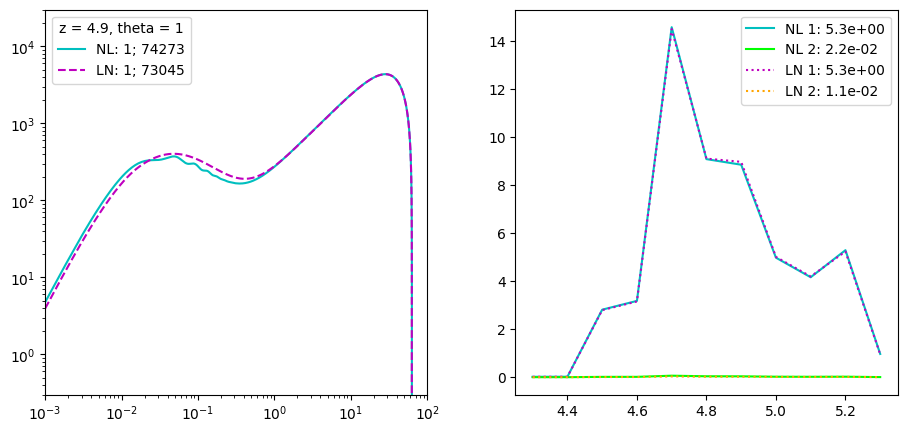

In [24]:
_PS_NORM_ = HOD.norm_power_spectrum()
M_h_array, HMF_array, nu_array, hmf_k, hmf_PS = HOD.init_lookup_table(z, REWRITE_TBLS=False)
NCEN = HOD.N_cen(M_h_array, M_min, sigma_logM)
NSAT = HOD.N_sat(M_h_array, M_sat, alpha, M_min, sigma_logM)
D_ratio   = (HOD.D_growth_factor(z)/HOD.D_growth_factor(0))**2 if z != 0 else 1
bias = Tinker10(nu=nu_array).bias() if 1 else HOD.halo_bias_TINKER(nu_array)
N_G  = HOD.n_g(M_min, sigma_logM, M_sat, alpha, z, M_h_array, HMF_array)
comoving_distance_z = cosmo.comoving_distance(z).value
crit_dens_rescaled = (4/3*np.pi*cosmo.critical_density(z).value*200*2e40)

USE_MY_PS = 0
if (USE_MY_PS):
    k_array = np.logspace(-3, 3, 2000)
    dlogk = np.log(k_array[1]/k_array[0])
else:
    k_array = hmf_k
    dlogk = np.log(hmf_k[1]/hmf_k[0])
PS_1 = [HOD.PS_1h(k, M_min, sigma_logM, M_sat, alpha, z, crit_dens_rescaled, M_h_array, HMF_array, N_G, NCEN, NSAT) for k in k_array]
PS_2 = [HOD.PS_2h(k, M_min, sigma_logM, M_sat, alpha, z, crit_dens_rescaled, M_h_array, HMF_array, N_G, NCEN, NSAT, bias, hmf_k, hmf_PS, D_ratio, _PS_NORM_, USE_MY_PS) for k in k_array]
PS_2_corr =  np.array(PS_2) if USE_MY_PS else hmf_PS * np.array(PS_2)
factor = np.array([HOD.factor_k(k, _theta_/206265, comoving_distance_z) for k in k_array])
F_k_hmf = (np.array(PS_1) + PS_2_corr) * factor
INT_hmf = 1#mpmath.quadosc(F_k_hmf, [0.001, mpmath.inf], period=2*np.pi)
INT_hmf_simps = integrate.simps(F_k_hmf, k_array)


USE_MY_PS = 1
if (USE_MY_PS):
    k_array = np.logspace(-3, 3, 2000)
    dlogk = np.log(k_array[1]/k_array[0])
else:
    k_array = hmf_k
    dlogk = np.log(hmf_k[1]/hmf_k[0])
PS_1 = [HOD.PS_1h(k, M_min, sigma_logM, M_sat, alpha, z, crit_dens_rescaled, M_h_array, HMF_array, N_G, NCEN, NSAT) for k in k_array]
PS_2 = [HOD.PS_2h(k, M_min, sigma_logM, M_sat, alpha, z, crit_dens_rescaled, M_h_array, HMF_array, N_G, NCEN, NSAT, bias, hmf_k, hmf_PS, D_ratio, _PS_NORM_, USE_MY_PS) for k in k_array]
PS_2_corr =  np.array(PS_2) if USE_MY_PS else hmf_PS * np.array(PS_2)
factor = np.array([HOD.factor_k(k, _theta_/206265, comoving_distance_z) for k in k_array])
F_k_anl = (np.array(PS_1) + PS_2_corr) * factor

def Integrand_k(k, theta, comoving_distance_z):
    k / (2*np.pi) * special.j0(k * theta * comoving_distance_z)

INT_anl = 1#mpmath.quadosc(F_k_anl, [0.001, mpmath.inf], period=2*np.pi)
INT_anl_simps = integrate.simps(F_k_anl, k_array)

fig, ax = plt.subplots(1, 2, figsize=(11, 5), sharex=False, sharey=False)
plt.subplots_adjust(wspace=.23, hspace=.2)
ax[0].plot(hmf_k, F_k_hmf, c = 'c', ls = '-', label = 'NL: '+str(int(INT_hmf))+'; '+str(int(INT_hmf_simps)))
ax[0].plot(k_array, F_k_anl, c = 'm', ls = '--', label = 'LN: '+str(int(INT_anl))+'; '+str(int(INT_anl_simps)))
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlim((1e-3, 1e2))
ax[0].set_ylim((3e-1, 3e4))
ax[0].legend(title=f'z = {z}, theta = {_theta_}')

H_z = [cosmo.H(z).value for z in z_array]
factor_z =  np.power(np.array(N_z_nrm), 2) / (c_light / np.array(H_z))

intg1 = [HOD.omega_z_component_1(z, _theta_/206265, M_min, sigma_logM, M_sat, alpha, NCEN, NSAT, _PS_NORM_, USE_MY_PS = 0, REWRITE_TBLS = False) for z in z_array]
intg2 = [HOD.omega_z_component_2(z, _theta_/206265, M_min, sigma_logM, M_sat, alpha, NCEN, NSAT, _PS_NORM_, USE_MY_PS = 0, REWRITE_TBLS = False) for z in z_array]
intg1_hmf, intg2_hmf = np.array(intg1), np.array(intg2)
OM1_hmf, OM2_hmf = np.trapz(intg1_hmf * factor_z, z_array), np.trapz(intg2_hmf * factor_z, z_array)

intg1 = [HOD.omega_z_component_1(z, _theta_/206265, M_min, sigma_logM, M_sat, alpha, NCEN, NSAT, _PS_NORM_, USE_MY_PS = 1, REWRITE_TBLS = False) for z in z_array]
intg2 = [HOD.omega_z_component_2(z, _theta_/206265, M_min, sigma_logM, M_sat, alpha, NCEN, NSAT, _PS_NORM_, USE_MY_PS = 1, REWRITE_TBLS = False) for z in z_array]
intg1_anl, intg2_anl = np.array(intg1), np.array(intg2)
OM1_anl, OM2_anl = np.trapz(intg1_anl * factor_z, z_array), np.trapz(intg2_anl * factor_z, z_array)

ax[1].plot(z_array, intg1_hmf * factor_z, c = 'c', ls = '-'     , label = f'NL 1: {OM1_hmf:.1e}')
ax[1].plot(z_array, intg2_hmf * factor_z, c = 'lime', ls = '-'  , label = f'NL 2: {OM2_hmf:.1e}')
ax[1].plot(z_array, intg1_anl * factor_z, c = 'm', ls = ':'     , label = f'LN 1: {OM1_anl:.1e}')
ax[1].plot(z_array, intg2_anl * factor_z, c = 'orange', ls = ':', label = f'LN 2: {OM2_anl:.1e}')
ax[1].legend()
plt.show()


In [323]:
if(1):
    z = 1.7
    M_sat, M_min, sigma_logM, alpha = 10**14.18, 10**12.46, 0.2, 1.0
    # M_sat, M_min, sigma_logM, alpha = 10**14.78, 10**12.46, 0.2, 1.0
    z_array = np.array([1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2])
    N_z_nrm = np.array([0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0])
elif(0):
    z = 1.7
    M_sat, M_min, sigma_logM, alpha = 10**12.48, 10**11.55, 0.2, 1.0
    z_array = np.array([1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2])
    N_z_nrm = np.array([0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0])
elif(0):
    z = 2.9
    M_sat, M_min, sigma_logM, alpha = 10**12.55, 10**11.71, 0.2, 1.0
    data = [
            [2.000000e+00, 2.017570e-02],
            [2.100000e+00, 5.120140e-02],
            [2.200000e+00, 8.963850e-02],
            [2.300000e+00, 1.257240e-01],
            [2.400000e+00, 1.558000e-01],
            [2.500000e+00, 2.025050e-01],
            [2.600000e+00, 2.320880e-01],
            [2.700000e+00, 3.334470e-01],
            [2.800000e+00, 3.349540e-01],
            [2.900000e+00, 4.237170e-01],
            [3.000000e+00, 4.196420e-01],
            [3.100000e+00, 4.230910e-01],
            [3.200000e+00, 4.523410e-01],
            [3.300000e+00, 3.643720e-01],
            [3.400000e+00, 1.837830e-01],
            [3.500000e+00, 4.229380e-02],
            [3.600000e+00, 3.679960e-02],
            [3.700000e+00, 3.273170e-02],
            [3.800000e+00, 5.401130e-02],
            [3.900000e+00, 2.088890e-02],
            [4.000000e+00, 1.080040e-02]
            ]
    z_array = np.array([row[0] for row in data])
    N_z_nrm = np.array([row[1] for row in data])
elif(0):
    z = 4.9
    M_sat, M_min, sigma_logM, alpha = 10**11.86, 10**11.57, 0.2, 1.0
    data = [
    (4.300000e+00, 1.300650e-02),
    (4.400000e+00, 1.332110e-02),
    (4.500000e+00, 1.609830e-01),
    (4.600000e+00, 1.659040e-01),
    (4.700000e+00, 3.460340e-01),
    (4.800000e+00, 2.671030e-01),
    (4.900000e+00, 2.569500e-01),
    (5.000000e+00, 1.880120e-01),
    (5.100000e+00, 1.704260e-01),
    (5.200000e+00, 1.871200e-01),
    (5.300000e+00, 7.831920e-02)
    ]
    z_array, N_z_nrm = np.array(data).T
else:
    z = 5.9
    M_sat, M_min, sigma_logM, alpha = 10**13.73, 10**12.09, 0.2, 1.0
    data = [
    (5.500000e+00, 2.321580e-02),
    (5.600000e+00, 5.284060e-02),
    (5.700000e+00, 1.436010e-01),
    (5.800000e+00, 1.481370e-01),
    (5.900000e+00, 1.036900e-01),
    (6.000000e+00, 1.342000e-01),
    (6.100000e+00, 2.453660e-01),
    (6.200000e+00, 1.546640e-01),
    (6.300000e+00, 1.127430e-02)
    ]
    z_array, N_z_nrm = np.array(data).T

M_h_array, HMF_array, nu_array, hmf_k, hmf_PS = HOD.init_lookup_table(z)
NTOT = HOD.N_tot(M_h_array, M_sat, alpha, M_min, sigma_logM)
N_g_AVG = HOD.get_AVG_N_tot(M_min, sigma_logM, M_sat, alpha, z)
M_h_AVG = HOD.get_AVG_Host_Halo_Mass(M_min, sigma_logM, M_sat, alpha, z)
b_eff = HOD.get_EFF_gal_bias(M_min, sigma_logM, M_sat, alpha, z, USE_MY_BIAS = 0)
f_sat = HOD.get_AVG_f_sat(M_min, sigma_logM, M_sat, alpha, z)
n_avg = HOD.get_N_dens_avg(z_array, M_min, sigma_logM, M_sat, alpha, z, N_z_nrm)

print(f'redshift z   : {z:.2f}')
print(f'n_avg        : {n_avg:.2e}')
print(f'N_g_AVG      : {N_g_AVG:.2e}')
print(f'log(M_h_AVG) : {np.log10(M_h_AVG):.2f}')
print(f'b_eff        : {b_eff:.2f}')
print(f'log(f_sat)   : {np.log10(f_sat):.2f}')
print(f'ln(f_sat)    : {np.log(f_sat):.2f}')

redshift z   : 1.70
n_avg        : 3.83e-04
N_g_AVG      : 3.90e-04
log(M_h_AVG) : 12.80
b_eff        : 2.58
log(f_sat)   : -1.42
ln(f_sat)    : -3.26


In [234]:
_theta_arcsec = np.logspace(-0.5, 3.5, 11)
theta = _theta_arcsec * 1/206265 # 1 arcsec in rad
omega1h, omega2h = HOD.omega_array(theta, M_min, sigma_logM, M_sat, alpha, N_z_nrm, z_array, USE_MY_PS = True, REWRITE_TBLS = False, USE_MY_BIAS = False)

  0%|          | 0/11 [00:00<?, ?it/s]

In [20]:
z = 1.7
# M_sat, M_min, sigma_logM, alpha = 10**14.18, 10**12.46, 0.2, 1.0
M_sat, M_min, sigma_logM, alpha = 10**14.78, 10**12.46, 0.2, 1.0
z_array = np.array([1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1])
N_z_nrm = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

z = 5.9
M_sat, M_min, sigma_logM, alpha = 10**13.73, 10**12.09, 0.2, 1.0
# M_sat, M_min, sigma_logM, alpha = 10**14.73, 10**13.09, 0.2, 1.0
data = [
(5.500000e+00, 2.321580e-02),
(5.600000e+00, 5.284060e-02),
(5.700000e+00, 1.436010e-01),
(5.800000e+00, 1.481370e-01),
(5.900000e+00, 1.036900e-01),
(6.000000e+00, 1.342000e-01),
(6.100000e+00, 2.453660e-01),
(6.200000e+00, 1.546640e-01),
(6.300000e+00, 1.127430e-02)
]
z_array, N_z_nrm = np.array(data).T

k_array = np.logspace(-5, 5, 100000)
ttttttt = np.logspace(-0.5, 3.5, 21)
o1, o2 = HOD_lowz.omega(ttttttt/206265, M_min, sigma_logM, M_sat, alpha, N_z_nrm, z_array, k_array = k_array)
# o1, o2 = HOD.omega_array(np.array([1, 5])/206265, M_min, sigma_logM, M_sat, alpha, N_z_nrm, z_array)

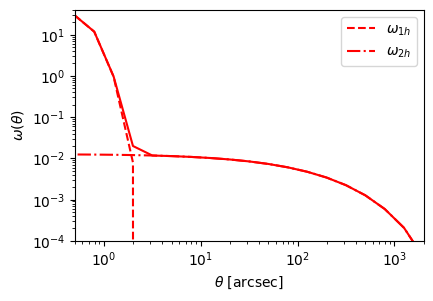

In [27]:
COL = 'k'
fig, ax = plt.subplots(1, 1, figsize=(4.5, 3), sharex=False, sharey=False)
# ax.plot(_theta_arcsec, omega1h, c = COL,ls = '--', label=r'$\omega_{1h}$')
# ax.plot(_theta_arcsec, omega2h, c = COL,ls = '-.', label=r'$\omega_{2h}$')
# ax.plot(_theta_arcsec, (omega1h+omega2h), c = COL,ls = '-')

ax.plot(ttttttt, o1, c = 'r', ls = '--', label=r'$\omega_{1h}$')
ax.plot(ttttttt, o2, c = 'r', ls = '-.', label=r'$\omega_{2h}$')
ax.plot(ttttttt, o1+o2, c = 'r', ls = '-')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim((0.5,2e3))
ax.set_ylim((1e-4,4e1))
ax.set_xlabel(r'$\theta$ [arcsec]')
ax.set_ylabel(r'$\omega$($\theta$)')
plt.legend()
plt.show()